# Training and validating LSTM + MPL model with the WHXE loss function

## Imports

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from LSTM_model import get_LSTM_Classifier
from dataloader import LSSTSourceDataSet, ts_length
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree, get_prediction_probs, get_highest_prob_path, plot_colored_tree

from argparse import ArgumentParser
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras

2024-05-04 15:50:18.963124: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 15:50:19.731687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 15:50:19.733279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 15:50:19.906693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 15:50:20.242732: I tensorflow/core/platform/cpu_feature_guar

## Load and balance the tensors:

In [2]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

X_ts = load("processed/train/x_ts.pkl")
X_static = load("processed/train/x_static.pkl")
Y = load("processed/train/y.pkl")
lengths = load("processed/train/lengths.pkl")
astrophysical_classes = load("processed/train/a_labels.pkl")
elasticc_classes = load("processed/train/e_label.pkl")

In [3]:
# Balance the data set in some way
max_class_count = 20000

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
lengths_balanced = []
astrophysical_classes_balanced = []
elasticc_classes_balanced = []

for c in np.unique(astrophysical_classes):

    idx = np.where(np.array(astrophysical_classes) == c)[0]
    
    if len(idx) > max_class_count:
        idx = idx[:max_class_count]
 
    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i]['MWEBV'] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]
    elasticc_classes_balanced += [elasticc_classes[i] for i in idx]

a, b = np.unique(astrophysical_classes_balanced, return_counts=True)
for c in zip(a, b):
    print(c)

('AGN', 20000)
('CART', 8207)
('Cepheid', 13771)
('Delta Scuti', 20000)
('Dwarf Novae', 8025)
('EB', 20000)
('ILOT', 7461)
('KN', 4426)
('M-dwarf Flare', 1859)
('PISN', 20000)
('RR Lyrae', 14033)
('SLSN', 20000)
('SNI91bg', 20000)
('SNII', 20000)
('SNIa', 20000)
('SNIax', 20000)
('SNIb/c', 20000)
('TDE', 20000)
('uLens', 17592)


In [4]:
# clear up memory
del X_ts
del X_static
del Y
del astrophysical_classes
del elasticc_classes

In [5]:
# Pad for TF masking layer
for ind in range(len(X_ts_balanced)):
    print(f"{(ind/len(X_ts_balanced) * 100):.3f} %", end="\r")
    X_ts_balanced[ind] = np.pad(X_ts_balanced[ind], ((0, ts_length - len(X_ts_balanced[ind])), (0, 0)))

In [6]:
# Split into train and validation
X_ts_train, X_ts_val, X_static_train, X_static_val, Y_train, Y_val, astrophysical_classes_train, astrophysical_classes_val, elasticc_classes_train, elasticc_classes_val = train_test_split(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, elasticc_classes_balanced, shuffle=True, random_state = 40, test_size = 0.05)

In [7]:
# clear up memory
del X_ts_balanced
del X_static_balanced
del Y_balanced
del astrophysical_classes_balanced
del elasticc_classes_balanced

In [8]:
# Do some processing for tensorflow
X_ts_train = np.squeeze(np.array(X_ts_train))
X_ts_val = np.squeeze(np.array(X_ts_val))

X_static_train = np.squeeze(np.array(X_static_train))
X_static_val = np.squeeze(np.array(X_static_val))

Y_train = np.squeeze(np.array(Y_train))
Y_val = np.squeeze(np.array(Y_val))

## Train the classifier using WHXE loss and save the model

In [9]:
# Loss and optimizer
tree = get_taxonomy_tree()
loss_object = WHXE_Loss(tree, astrophysical_classes_train) 
criterion = loss_object.compute_loss

In [10]:
# Inputs for model
ts_dim = 5
static_dim = 1
output_dim = 26
latent_size = 64

num_epochs = 50
batch_size = 1024

In [11]:
model = get_LSTM_Classifier(ts_dim, static_dim, output_dim, latent_size, criterion)

2024-05-04 15:54:50.305862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2024-05-04 15:54:50.307175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31127 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0


In [12]:

early_stopping = EarlyStopping(
                          patience=5,
                          min_delta=0.001,                               
                          monitor="val_loss",
                          restore_best_weights=True
                          )


history = model.fit(x = [X_ts_train, X_static_train],  y = Y_train, validation_data=([X_ts_val, X_static_val], Y_val), epochs=num_epochs, batch_size = batch_size, callbacks=[early_stopping])


model.save(f"models/lstm.keras")

Epoch 1/50


2024-05-04 15:55:08.687789: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_35/output/_22'
2024-05-04 15:55:09.354566: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2024-05-04 15:55:10.867919: I external/local_xla/xla/service/service.cc:168] XLA service 0x149ca16ce4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-04 15:55

275/275 [==============================] - 34s 87ms/step - loss: 0.2390 - accuracy: 4.9892e-05 - val_loss: 0.2120 - val_accuracy: 0.0000e+00
Epoch 2/50
275/275 [==============================] - 22s 80ms/step - loss: 0.1851 - accuracy: 0.0000e+00 - val_loss: 0.1668 - val_accuracy: 0.0000e+00
Epoch 3/50
275/275 [==============================] - 22s 80ms/step - loss: 0.1547 - accuracy: 0.0000e+00 - val_loss: 0.1528 - val_accuracy: 0.0000e+00
Epoch 4/50
275/275 [==============================] - 22s 80ms/step - loss: 0.1329 - accuracy: 0.0000e+00 - val_loss: 0.1264 - val_accuracy: 0.0000e+00
Epoch 5/50
275/275 [==============================] - 22s 80ms/step - loss: 0.1205 - accuracy: 0.0000e+00 - val_loss: 0.1305 - val_accuracy: 0.0000e+00
Epoch 6/50
275/275 [==============================] - 22s 80ms/step - loss: 0.1118 - accuracy: 0.0000e+00 - val_loss: 0.1521 - val_accuracy: 0.0000e+00
Epoch 7/50
275/275 [==============================] - 22s 80ms/step - loss: 0.1094 - accuracy: 0.00

## Load the saved model and validate everthing looks okay

In [13]:
model1 = keras.models.load_model(f"models/lstm.keras", compile=False)

In [14]:
Y_val_pred = model1.predict([X_ts_val, X_static_val])

for i in range(Y_val_pred.shape[0]):
    
    pseudo_probs, weighted_tree = get_prediction_probs(Y_val_pred[[i], :])
    leaf_prob , _ = get_highest_prob_path(weighted_tree)
    Y_val_pred[i, -19:] =  leaf_prob
    
Y_val_pred = np.argmax(Y_val_pred[:, -19:], axis=1)
Y_val_true = np.argmax(Y_val[:, -19:], axis=1)

462/462 [==============================] - 6s 9ms/step


In [15]:
report = classification_report(Y_val_true, Y_val_pred, target_names=list(loss_object.level_order_nodes)[-19:], output_dict=True)
df = pd.DataFrame(report).transpose()
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &       support \\
\midrule
AGN           &   0.898095 &  0.929980 &  0.913760 &   1014.000000 \\
SNIa          &   0.472597 &  0.526000 &  0.497870 &   1000.000000 \\
SNIb/c        &   0.514523 &  0.394904 &  0.446847 &    942.000000 \\
SNIax         &   0.357881 &  0.538387 &  0.429957 &   1029.000000 \\
SNI91bg       &   0.749736 &  0.705065 &  0.726714 &   1007.000000 \\
SNII          &   0.692140 &  0.628345 &  0.658701 &   1009.000000 \\
KN            &   0.710714 &  0.892377 &  0.791252 &    223.000000 \\
Dwarf Novae   &   0.916883 &  0.878109 &  0.897078 &    402.000000 \\
uLens         &   0.890625 &  0.937500 &  0.913462 &    912.000000 \\
M-dwarf Flare &   0.614583 &  0.737500 &  0.670455 &     80.000000 \\
SLSN          &   0.856157 &  0.746988 &  0.797855 &    996.000000 \\
TDE           &   0.896896 &  0.828893 &  0.861555 &    976.000000 \\
ILOT          &   0.640199 &  0.658163 &  0.649057 &    392.

/var/tmp/ipykernel_23683/940963380.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


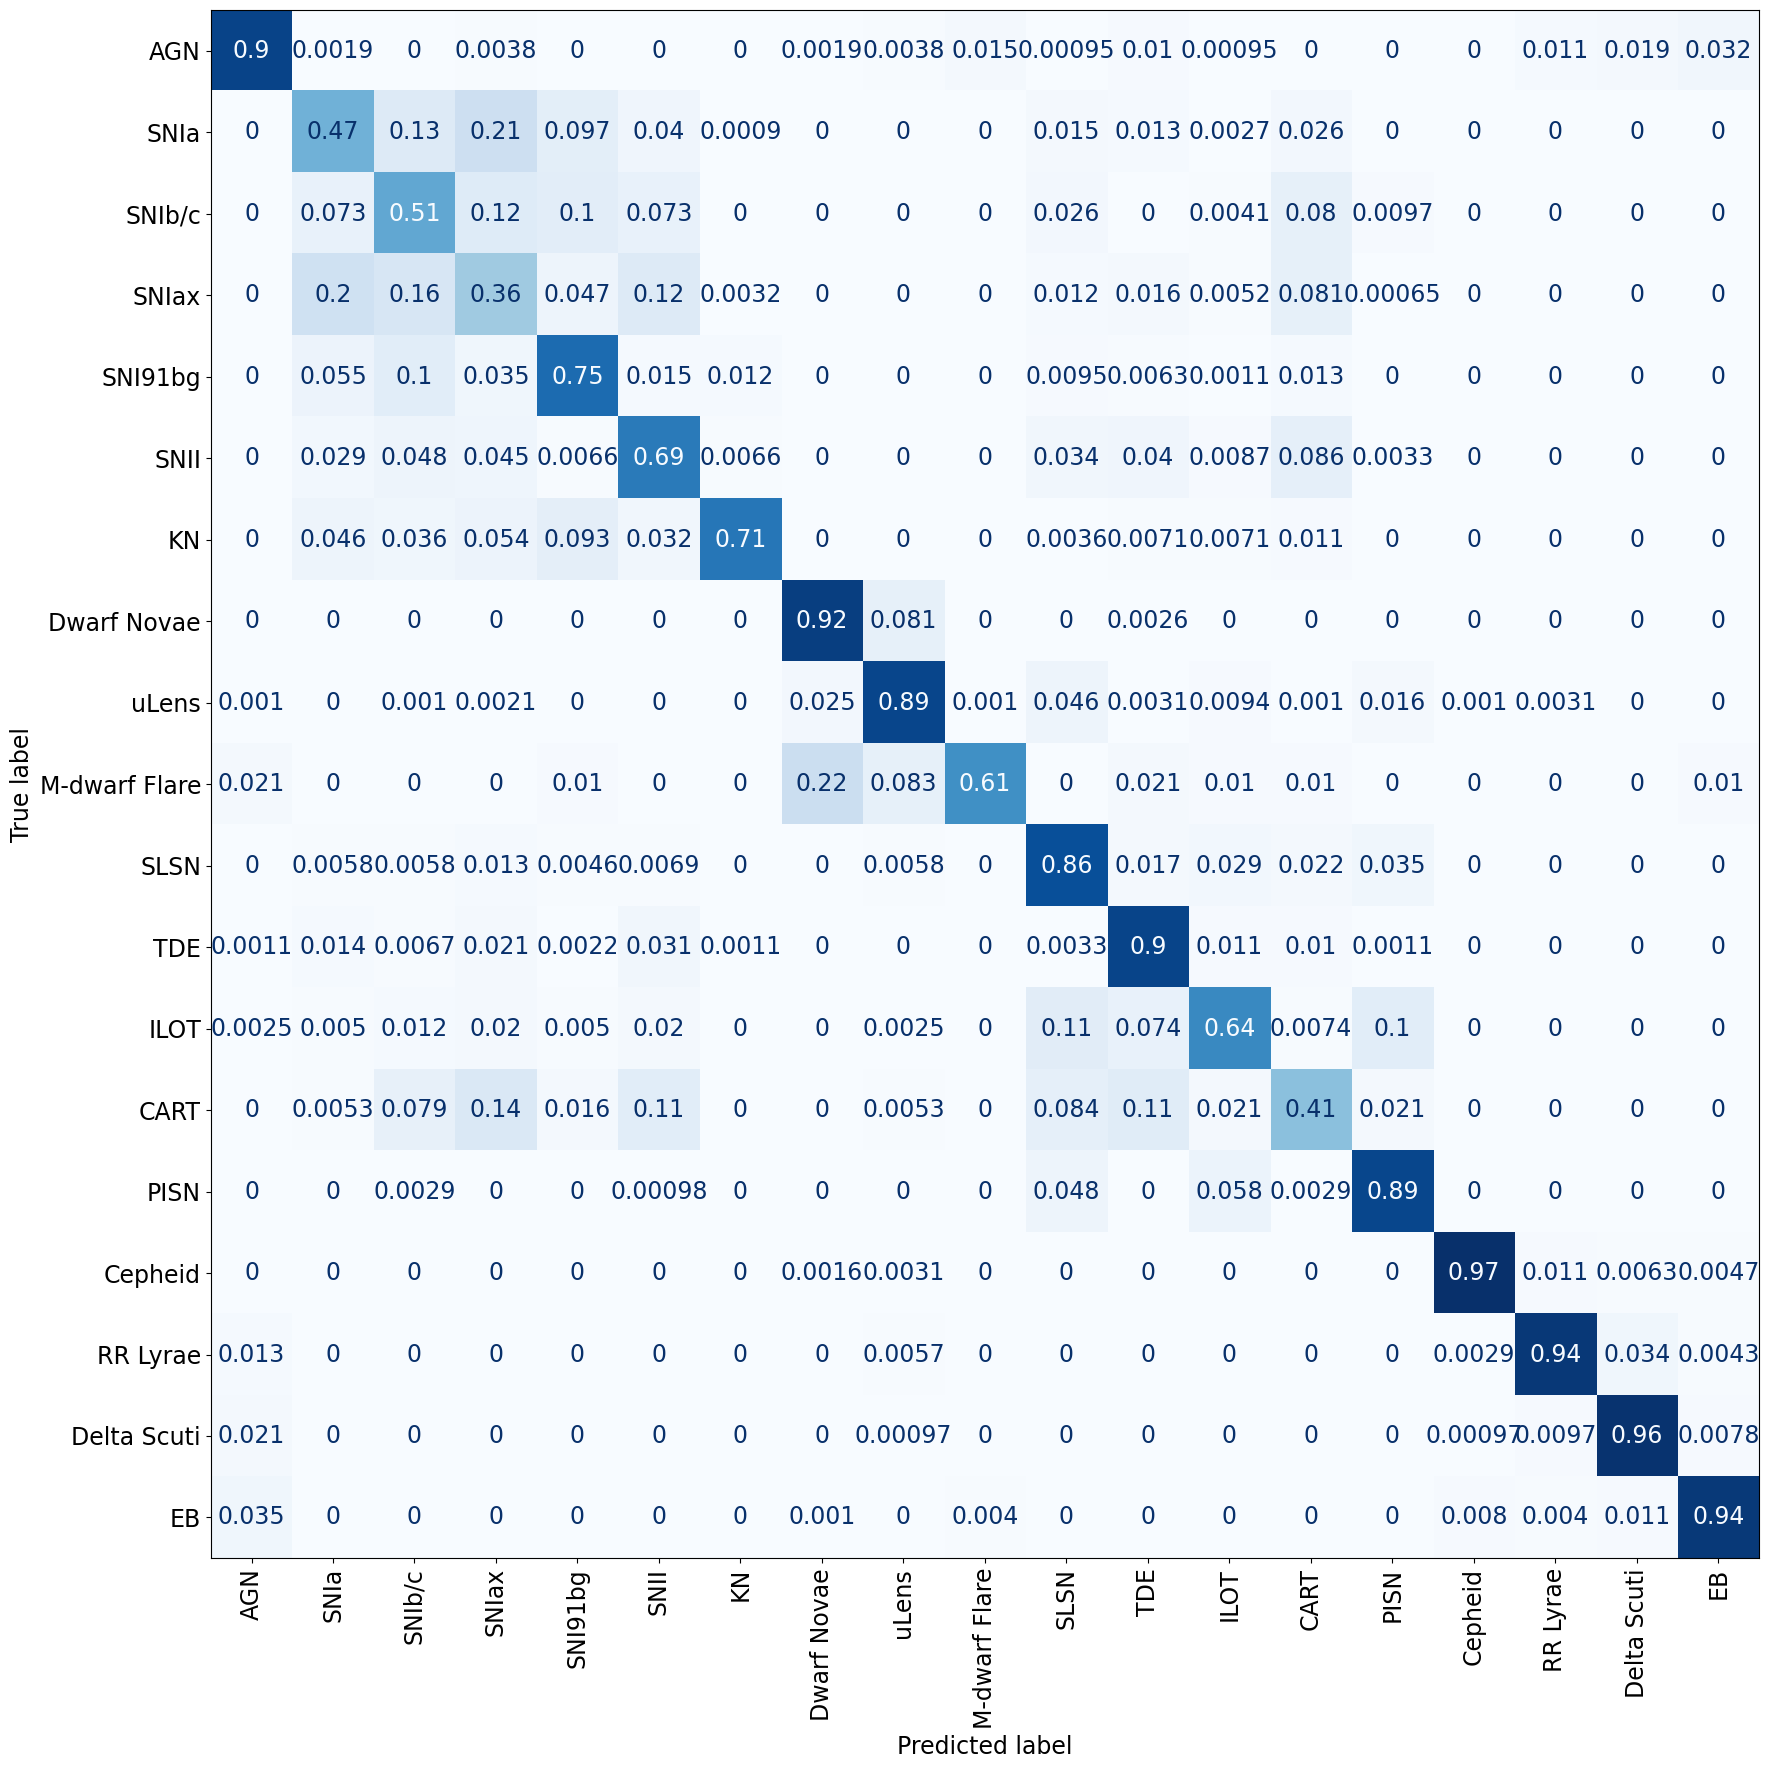

In [16]:
font = {'size'   : 17}
plt.rc('font', **font)

cm = confusion_matrix(Y_val_pred, Y_val_true, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(loss_object.level_order_nodes)[-19:])
disp.plot(cmap=plt.cm.Blues)
disp.im_.colorbar.remove()

fig = disp.figure_
plt.xticks(rotation=90)


fig.set_figwidth(18)
fig.set_figheight(18)
plt.tight_layout()
plt.savefig('baseline_leaves.pdf')

In [24]:
Y_val_pred = model1.predict([X_ts_val, X_static_val])
Y_val_pred = np.argmax(Y_val_pred[:, 1:3], axis=1)
Y_val_true = np.argmax(Y_val[:, 1:3], axis=1)

442/442 [==============================] - 4s 9ms/step


In [25]:
report = classification_report(Y_val_true, Y_val_pred, target_names=list(loss_object.level_order_nodes)[1:3], output_dict=True)
df = pd.DataFrame(report).transpose()
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &       support \\
\midrule
Transient    &   0.996987 &  0.986289 &  0.991609 &  10065.000000 \\
Variable     &   0.966811 &  0.992593 &  0.979532 &   4050.000000 \\
accuracy     &   0.988098 &  0.988098 &  0.988098 &      0.988098 \\
macro avg    &   0.981899 &  0.989441 &  0.985571 &  14115.000000 \\
weighted avg &   0.988329 &  0.988098 &  0.988144 &  14115.000000 \\
\bottomrule
\end{tabular}



/var/tmp/ipykernel_33642/2644172534.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


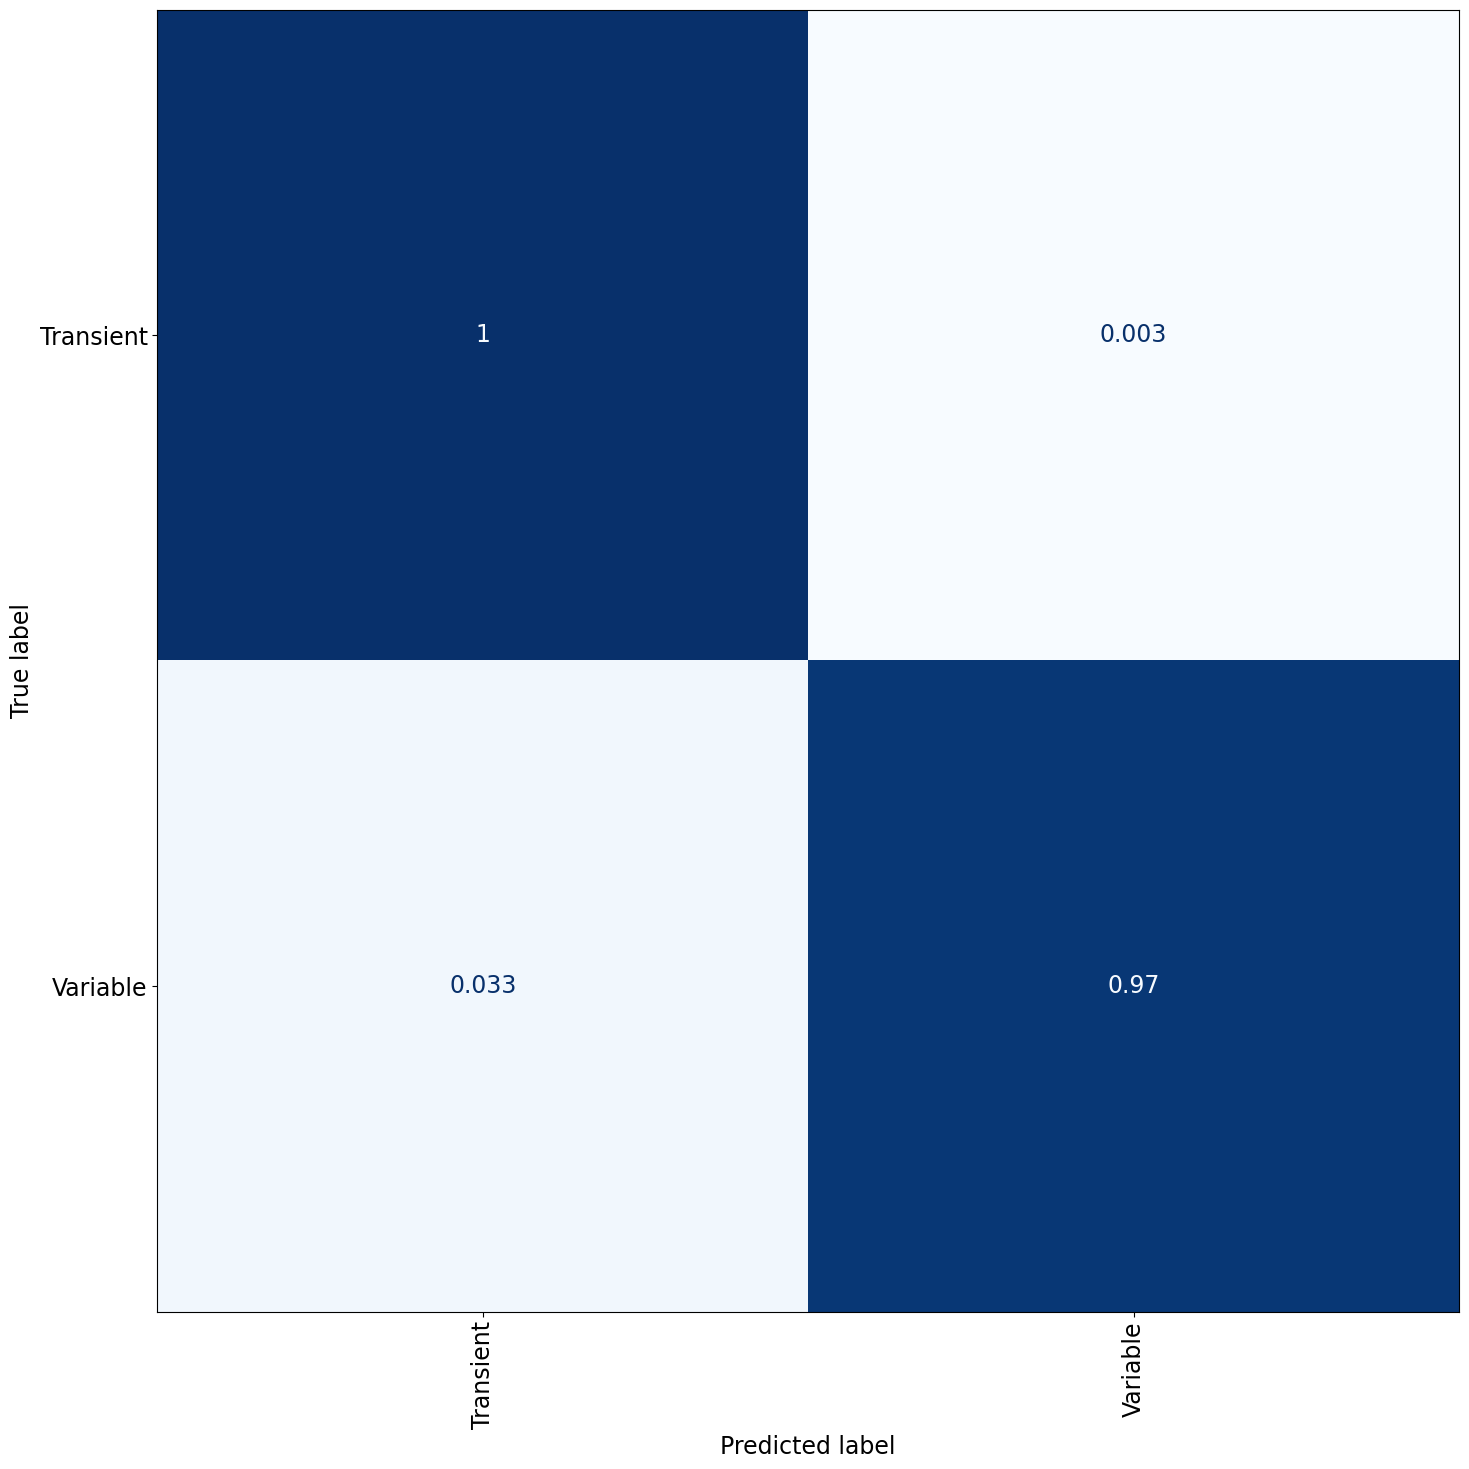

In [27]:
font = {'size'   : 17}
plt.rc('font', **font)

cm = confusion_matrix(Y_val_pred, Y_val_true, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(loss_object.level_order_nodes)[1:3])
disp.plot(cmap=plt.cm.Blues)
disp.im_.colorbar.remove()

fig = disp.figure_
plt.xticks(rotation=90)


fig.set_figwidth(15)
fig.set_figheight(15)
plt.tight_layout()
plt.savefig('baseline_root.pdf')

For the love of everthing that is good in this world, please use a different notebook for testing and genearting statistics. Keep this notebook simple enought to be converted into a script. 